# Getting Started

In this notebook we use `boax` to implement a simple bayesian optimization workflow.

The process, generally, consists of three steps:
1. Fitting a surrogate model to training data
2. Constructing an acquisition function and selecting the highest scoring batch of data points
3. Evaluating the objective function and updating the training data

## Setting up the environment

In [1]:
from jax import config

config.update("jax_enable_x64", True)

from jax import numpy as jnp
from jax import jit, lax, nn, random, value_and_grad, vmap

import optax
import matplotlib.pyplot as plt

plt.style.use('bmh')

from boax.core import distributions, samplers
from boax.prediction import models, objectives
from boax.optimization import acquisitions, optimizers

As part of the setup we initialize a PRNG key with a starting seed of 0. We will make use of it later in the notebook.

In [2]:
key = random.key(0)

## Defining the latent objective function

In bayesian optimization we treat the objective as an expensive to evaluate black box function. Hence, there are a limited number of times we can afford to query the objective function. For this example we choose a modified 1-dimensional Forrester function, that we aim to maximize in the interval of `[-5, 5]`.

In [3]:
def objective(x):
    return -((x[..., 0] + 1) ** 2) * jnp.sin(2 * x[..., 0] + 2) / 5 + 1

When defining the objective function we expect an input of shape `(n, d)`, where `n` indicates the number of examples in the training set and `d` indicates the number of dimensions for each data point.

In [4]:
bounds = jnp.array([[-5.0, 5.0]])

The bounds are of shape `(d, 2)`, where `d` indicates the number of dimensions, each described by a lower and upper bound.

## Generating training data

In this example we assume to have already evaluated the objective function at the points `x=1` and `x=2`. These will serve as a starting point for the optimization process. 

In [5]:
x_train = jnp.array([[1.0], [2.0]])
y_train = objective(x_train)

In the following we plot the observations from the evaluation in the context of the latent objective function.

In [6]:
xs = jnp.linspace(bounds[:, 0], bounds[:, 1], 501)
ys = objective(xs)

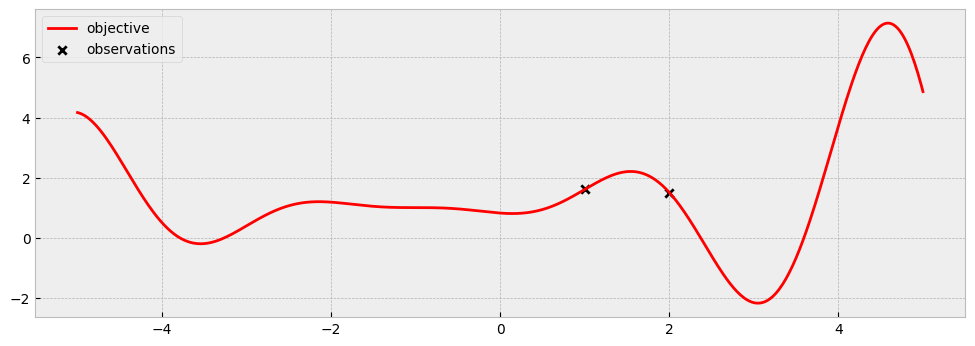

In [7]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(xs, ys, c='r', label='objective')
ax.scatter(x_train, y_train, marker='x', c='k', label='observations')
ax.legend()

plt.show()

## Fitting a Gaussian Process model to the data

With the observations in place, we can now focus on fitting a Gaussian Process model to the training data. We choose a simple Gaussian Process model setup with a constant mean function, a scaled RBF kernel, and a gaussian likelihood.

In [8]:
def model_fn(params, x_train, y_train):
    return models.gaussian_process(
        models.means.constant(params['mean']),
        models.kernels.scaled(
            models.kernels.rbf(nn.softplus(params['length_scale'])),
            nn.softplus(params['amplitude'])
        ),
        models.likelihoods.gaussian(1e-4),
        x_train,
        y_train,
    )

Next, we define the loss function used to fit the model to the training data. For this setup we select the negative log likelihood.

In [9]:
def loss_fn(params, x_train, y_train):
    y_hat = model_fn(params, None, None)(x_train)
    objective = objectives.negative_log_likelihood(
        distributions.multivariate_normal.logpdf
    )

    return objective(y_hat, y_train)

Subsequentely, we initialise the model parameters and the optimizer from the `optax` library.

In [10]:
params = {
    'mean': jnp.zeros(()),
    'length_scale': jnp.zeros(()),
    'amplitude': jnp.zeros(()),
}

In [11]:
adam = optax.adam(0.01)

Finally, we have everything we need to define the model fitting function.

In [12]:
def fit(x_train, y_train):
    def step(state, i):
        loss, grads = value_and_grad(loss_fn)(state[0], x_train, y_train)
        updates, opt_state = adam.update(grads, state[1])
        params = optax.apply_updates(state[0], updates)

        return (params, opt_state), loss

    (next_params, _), _ = lax.scan(
        jit(step),
        (params, adam.init(params)),
        jnp.arange(500),
    )

    return next_params

## Constructing an acquisition function and selecting the next data points to query

The next step in the bayesian optimization process is the construction of an acqusition function that guides our decision of selecting a new point to query the latent objective function. For this example we select the Upper Confidence Bound (UCB) acquisition function, which we optimize using the BFGS optimizer.

In [13]:
def acquisition_fn(model):
    ucb = acquisitions.upper_confidence_bound(2.0)
    
    def fn(x):
        return ucb(vmap(model)(x))

    return fn

In [14]:
bfgs = optimizers.batch(
    initializer=optimizers.initializers.q_batch(),
    solver=optimizers.solvers.scipy(method='bfgs'),
)

In [15]:
batch_size = 1
num_samples = 100
num_restarts = 10

## Running the experiment

Finally we have everything setup to run the bayesian optimization loop. In order to better retrace the process we define visualisation function that plots our current believe of the latent objective function and the acquisition function at each step.

In [16]:
def visualize(model, acqf, next_x):
    loc, scale = model(xs)
    scores = acqf(xs[..., jnp.newaxis])
    
    fig, axs = plt.subplots(
        2,
        1,
        figsize=(12, 6),
        sharex=True,
        gridspec_kw={'height_ratios': [2, 1]}
    )

    axs[0].plot(xs, ys, c='r', label='objective')
    axs[0].scatter(x_train, y_train, marker='x', c='k', label='observations')
    axs[0].plot(xs, loc, label='mean')
    axs[0].fill_between(
        xs.flatten(),
        loc - 2 * scale,
        loc + 2 * scale,
        alpha=0.3,
        label='95% CI'
    )

    axs[0].axvline(next_x, linestyle='dotted', c='k')

    axs[0].legend(loc='upper left')
    axs[0].set_ylabel('predictive')

    axs[1].plot(xs, scores, c='g')
    axs[1].fill_between(
        xs.flatten(),
        scores,
        0,
        color='g',
        alpha=0.5,
    )

    axs[1].axvline(next_x, linestyle='dotted', c='k')

    axs[1].set_ylabel('acquisition score')

    plt.show()

The bayesian optimization loop is implemented according the three steps of fitting, optimizing, evaluating. For our experiment we run the loop over 10 iterations and observe that this setup is enough to identify the global optimum.

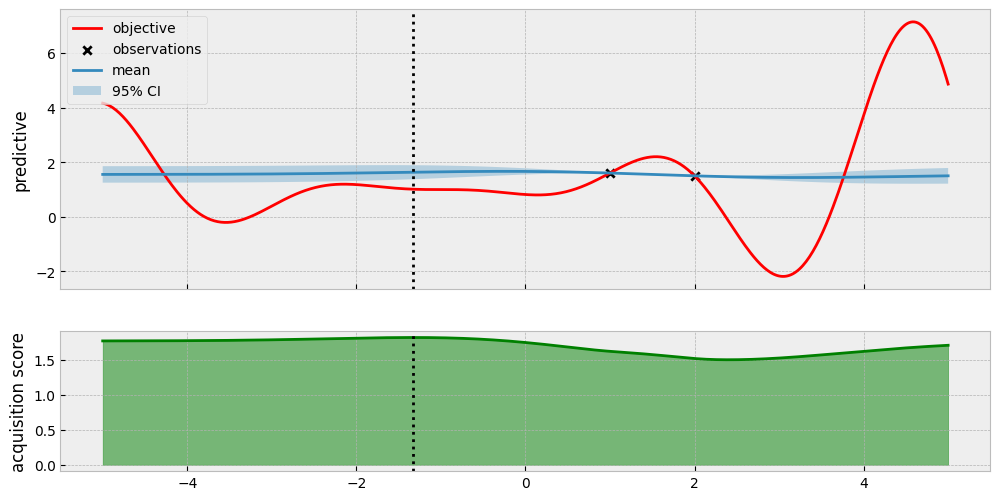

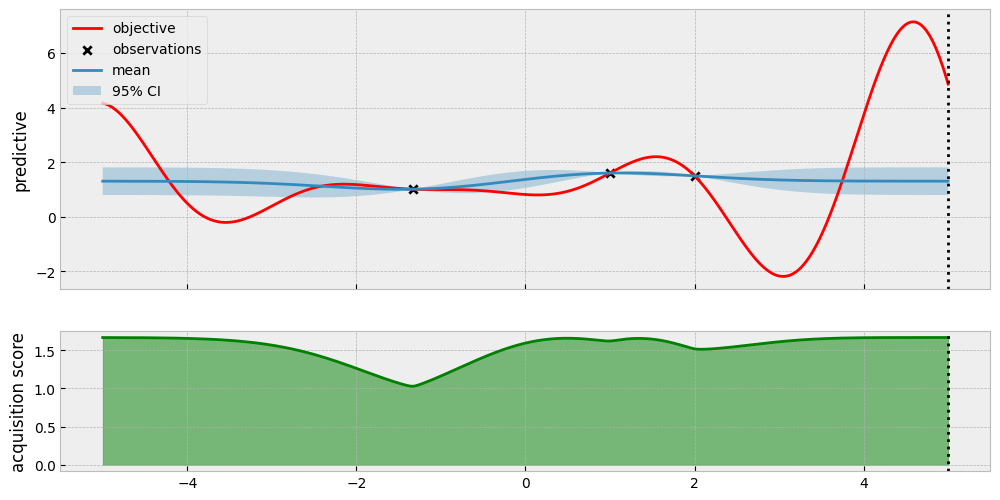

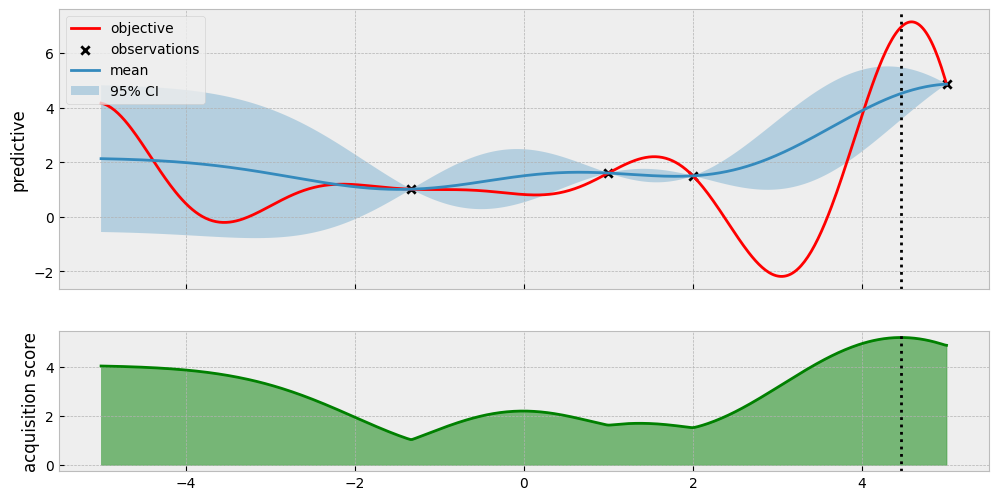

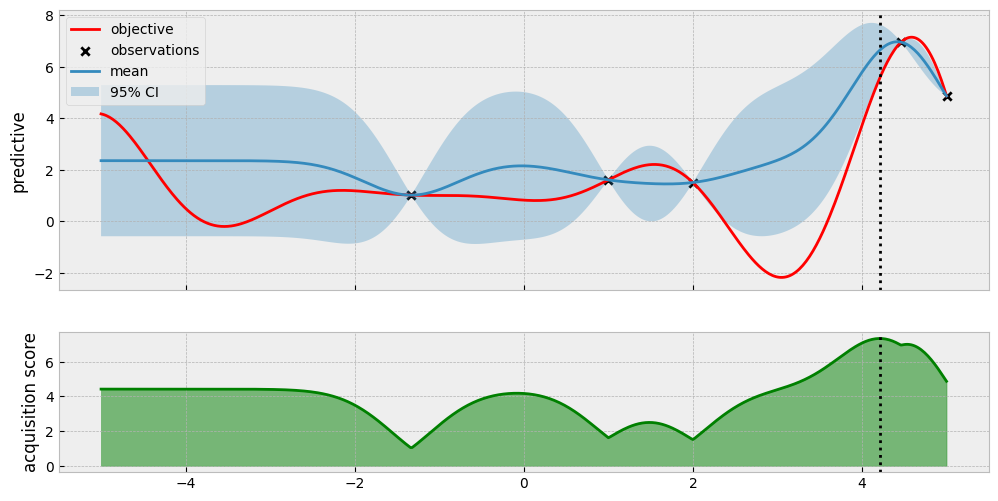

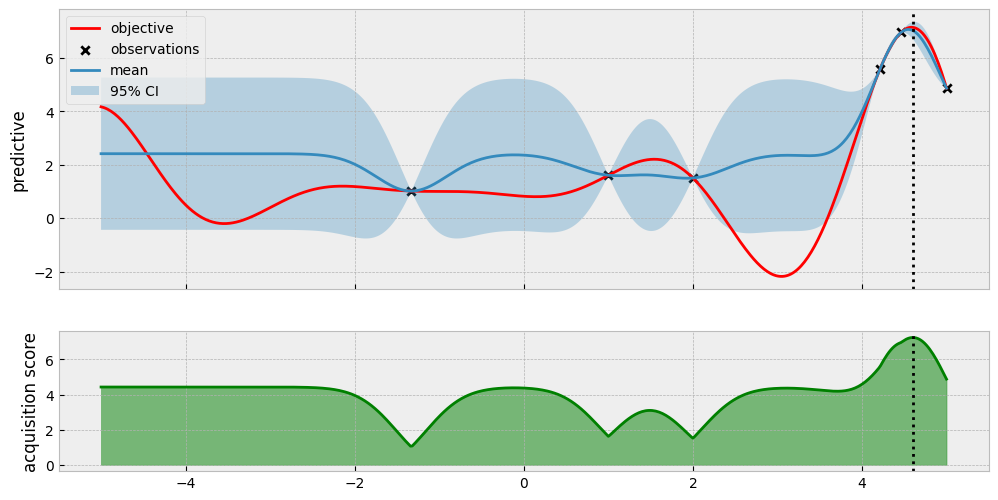

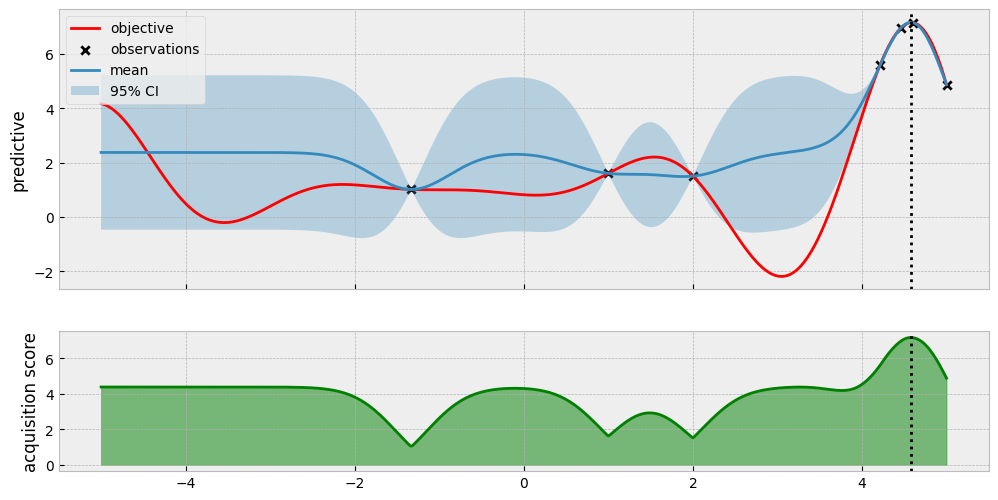

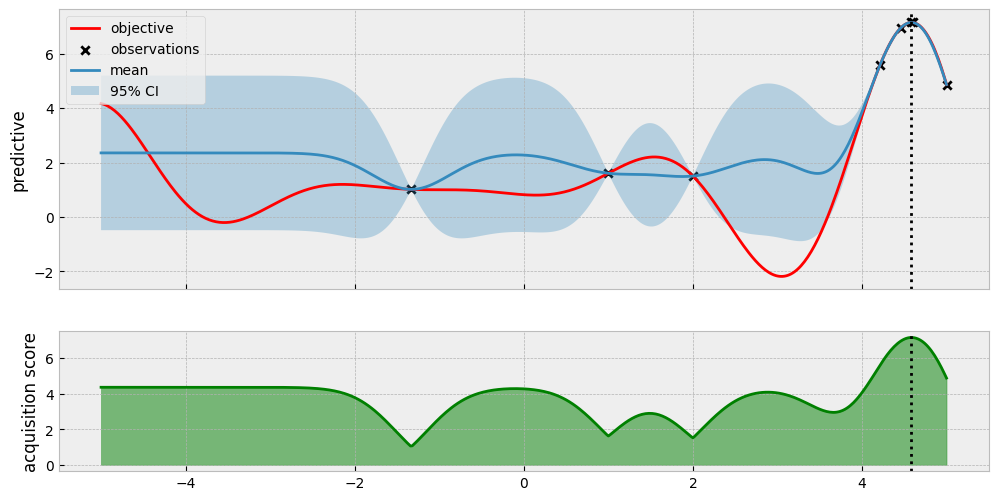

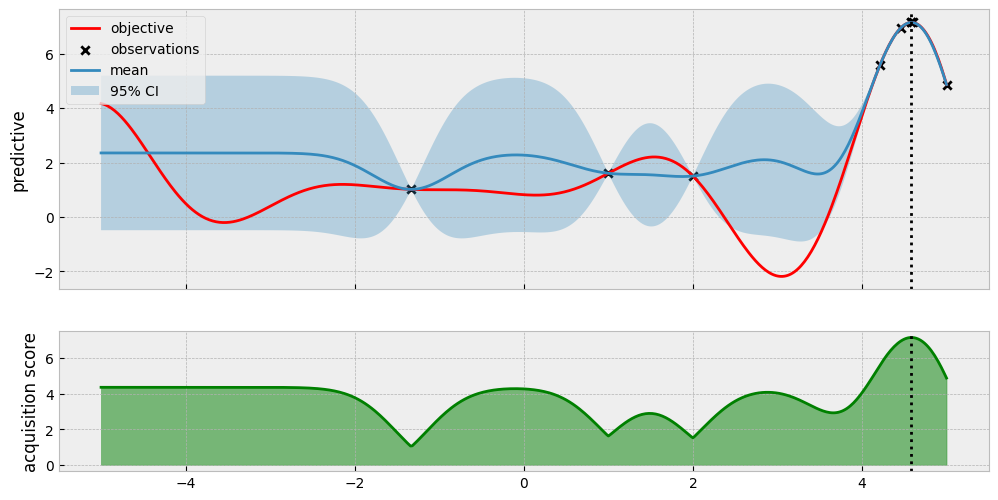

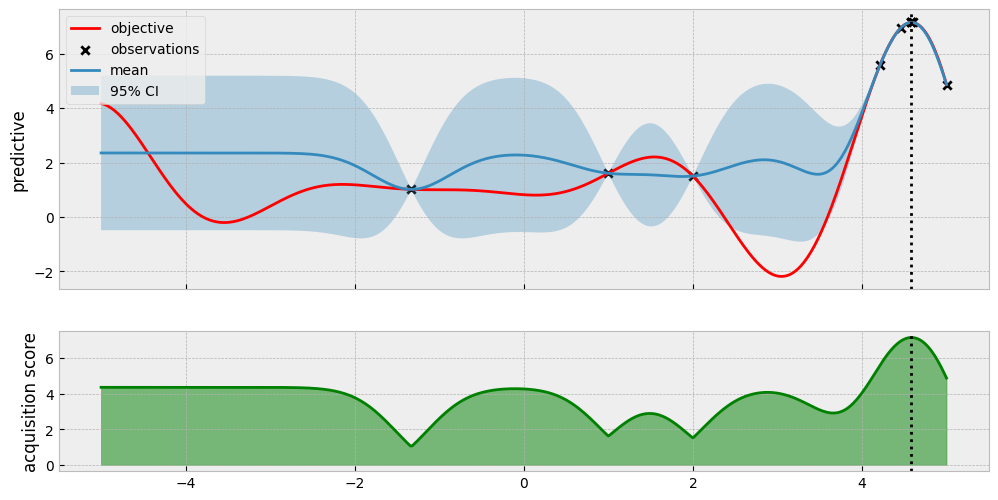

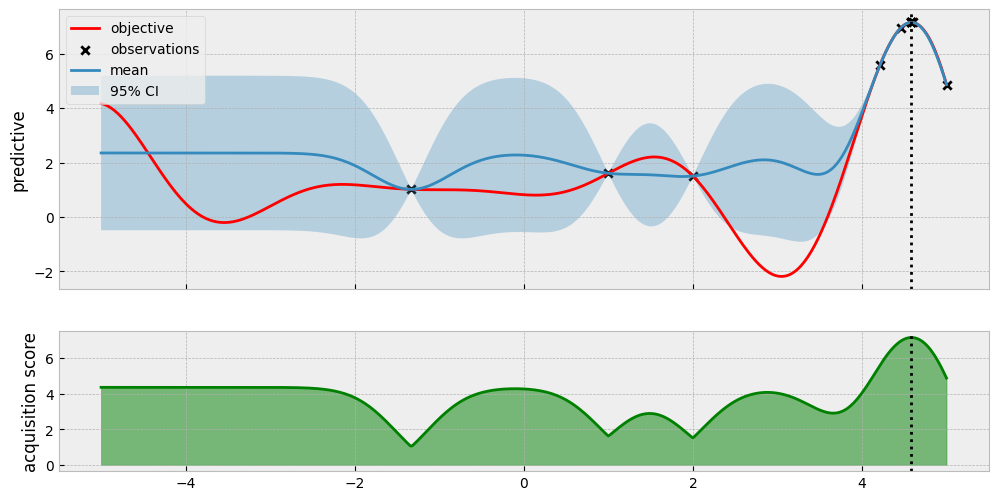

In [17]:
for i in range(10):
    # Fitting
    next_params = fit(x_train, y_train)
    
    model = models.outcome_transformed(
        model_fn(next_params, x_train, y_train),
        distributions.mvn_to_norm,
    )

    # Selecting
    acqf = acquisition_fn(model)
    
    next_x, _ = bfgs(
        random.fold_in(key, i),
        acqf,
        bounds,
        batch_size,
        num_samples,
        num_restarts,
    )

    # Evaluating
    next_y = objective(next_x)

    # Visualizing
    visualize(
        model,
        acqf,
        next_x,
    )

    # Updating the training data
    x_train = jnp.vstack([x_train, next_x])
    y_train = jnp.hstack([y_train, next_y])